In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from tqdm.notebook import tqdm
import random
import torch

# --- 实验设置 ---
T = 6000                 # 我们将创建 6000 步的数据流
TARGET_ALPHA = 0.1       # 我们的长期目标 α

# --- 算法 1: 原版 ACI (固定 γ) ---
GAMMA_FIXED = 0.05       # 一个"调得还行"的固定 γ

# --- 算法 2: 我们的 ACI-CF (动态 γ_t, 使用滑动窗口漂移检测) ---
GAMMA_MIN = 0.01         # 最小 γ
GAMMA_MAX = 0.15         # 最大 γ
WINDOW_SIZE = 100        # 用于 error gap / local error 的窗口大小
SLIDING_WINDOW_SIZE = 20  # 滑动窗口大小，用于计算局部漂移（相对于最近历史的距离）

# --- MMLU 主题定义 ---
DATA_FILE = "mmlu_with_aps_scores.csv"
try:
    df_temp = pd.read_csv(DATA_FILE)
    all_subjects = sorted(df_temp['subject'].unique())
    print(f"CSV中所有可用的subjects ({len(all_subjects)}个):")
    print(all_subjects)
    print()
    
    # 随机选择用于校准和测试的subjects
    random.seed(42)  # 设置随机种子以便结果可复现
    selected_subjects = random.sample(all_subjects, min(2, len(all_subjects)))
    CALIBRATION_SUBJECTS = selected_subjects[:1]
    TEST_STREAM_SUBJECTS = selected_subjects[1:]
    
    print(f"随机选择的校准subjects ({len(CALIBRATION_SUBJECTS)}个): {CALIBRATION_SUBJECTS}")
    print(f"随机选择的测试subjects ({len(TEST_STREAM_SUBJECTS)}个): {TEST_STREAM_SUBJECTS}")
except FileNotFoundError:
    print(f"警告: 未找到 {DATA_FILE}")


CSV中所有可用的subjects (19个):
['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology']

随机选择的校准subjects (1个): ['business_ethics']
随机选择的测试subjects (1个): ['abstract_algebra']


In [2]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

print("SentenceTransformer library loaded.")


SentenceTransformer library loaded.


In [3]:
# -----------------------------------------------------------------
# Section 2: 加载数据 & 创建 *分裂的* "固定模型" Q_hat
# -----------------------------------------------------------------

from sklearn.model_selection import train_test_split

# 加载数据
DATA_FILE = "mmlu_with_aps_scores.csv"
try:
    df_scores = pd.read_csv(DATA_FILE)
    print(f"成功加载 {len(df_scores)} 行 MMLU 数据。")
except FileNotFoundError:
    print(f"错误: 未找到 {DATA_FILE}")
    print("请确保你已成功运行第一个 notebook 并生成了该文件。")


# --- 1. 划分"校准主题"和"OOD主题" ---
df_cal_pool = df_scores[df_scores['subject'].isin(CALIBRATION_SUBJECTS)]
df_ood_pool = df_scores[df_scores['subject'].isin(TEST_STREAM_SUBJECTS)]

# --- 2. 找到"校准主题"的所有唯一 question_id ---
cal_all_qids = df_cal_pool['question_id'].unique()
print(f"从 {len(CALIBRATION_SUBJECTS)} 个校准主题中找到 {len(cal_all_qids)} 个唯一的问题。")

# --- 3. 将这些问题 50/50 分裂 ---
# D_cal 用于构建 Q_hat
# D_test_id 用于模拟"稳定/分布内"的测试流
cal_qids, test_id_qids = train_test_split(cal_all_qids, test_size=0.5, random_state=42)

print(f" -> {len(cal_qids)} 个问题用于构建 Q_hat (Calibration)")
print(f" -> {len(test_id_qids)} 个问题用于稳定测试流 (In-Distribution Test)")


# --- 4. 创建我们的"固定模型" Q_hat ---
df_cal = df_scores[df_scores['question_id'].isin(cal_qids)]
calibration_scores = df_cal[df_cal['is_ground_truth'] == True]['aps_score'].values
print(f"\n成功从 {len(calibration_scores)} 个校准分数构建 Q_hat。")

# 我们的模型 Q_hat(q) 就是这些校准分数的 *经验分位数* 函数
def hat_Q(q_level):
    if q_level <= 0: return -np.inf
    if q_level >= 1: return np.inf
    # 使用 'higher' 来匹配 (n+1)/n 的保守估计
    return np.quantile(calibration_scores, q_level, method='higher')

# 测试一下我们的 Q_hat
q_90 = hat_Q(1.0 - TARGET_ALPHA)
print(f"我们的固定阈值 q_hat (在 α=0.1 时) 是: {q_90:.4f}")


成功加载 11916 行 MMLU 数据。
从 1 个校准主题中找到 100 个唯一的问题。
 -> 50 个问题用于构建 Q_hat (Calibration)
 -> 50 个问题用于稳定测试流 (In-Distribution Test)

成功从 50 个校准分数构建 Q_hat。
我们的固定阈值 q_hat (在 α=0.1 时) 是: 0.2560


In [4]:
# -----------------------------------------------------------------
# *** 预计算所有 MMLU 问题的 Embeddings ***
# -----------------------------------------------------------------
print("\n--- 正在预计算 Embeddings ---")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 1. 加载一个轻量级的 SBERT 模型
embed_model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)

# 2. 获取 *所有* 唯一的 MMLU 问题 (来自 df_scores)
unique_questions = df_scores[['question_id', 'question']].drop_duplicates().set_index('question_id')
question_texts = unique_questions['question'].tolist()
question_ids = unique_questions.index.tolist()

print(f"正在为 {len(question_texts)} 个唯一问题计算 embeddings...")

# 3. 计算所有 embeddings
question_embeddings = embed_model.encode(
    question_texts, 
    batch_size=32, 
    show_progress_bar=True, 
    device=DEVICE
)

print("Embeddings 计算完成。")

# 4. 创建一个从 question_id -> embedding 的快速查找字典
embedding_map = {qid: emb for qid, emb in zip(question_ids, question_embeddings)}

# 5. 将 embeddings 添加到我们的主 DataFrame 中
df_scores['embedding'] = df_scores['question_id'].map(embedding_map)
print("Embeddings 已合并回主 DataFrame。")



--- 正在预计算 Embeddings ---
正在为 2979 个唯一问题计算 embeddings...


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings 计算完成。
Embeddings 已合并回主 DataFrame。


In [5]:
# -----------------------------------------------------------------
# Section 3: 创建"连续跳跃"测试数据流（多个 jump，多个 non-iid subjects）
# -----------------------------------------------------------------

# --- 1. 准备好我们的问题"池" ---

# (A) "稳定 / 分布内" (ID) 问题池
df_test_id_data = df_scores[df_scores['question_id'].isin(test_id_qids)]
df_test_id_gt = df_test_id_data[df_test_id_data['is_ground_truth'] == True].copy()
df_test_id_gt = df_test_id_gt.rename(columns={'choice_index': 'ground_truth_label'})
pool_id = df_test_id_gt[['question_id', 'ground_truth_label', 'embedding']]
print(f"创建了 {len(pool_id)} 个问题的稳定 (ID) 池。")

# (B) "剧变 / 分布外" (OOD) 问题池 - 按 subject 分组
df_test_ood_data = df_scores[df_scores['subject'].isin(TEST_STREAM_SUBJECTS)]
df_test_ood_gt = df_test_ood_data[df_test_ood_data['is_ground_truth'] == True].copy()
df_test_ood_gt = df_test_ood_gt.rename(columns={'choice_index': 'ground_truth_label'})

# 按 subject 分组，为每个 subject 创建独立的池
pool_ood_by_subject = {}
for subject in TEST_STREAM_SUBJECTS:
    subject_data = df_test_ood_gt[df_test_ood_gt['question_id'].str.startswith(subject)]
    if len(subject_data) > 0:
        pool_ood_by_subject[subject] = subject_data[['question_id', 'ground_truth_label', 'embedding']]
        print(f"  Subject '{subject}': {len(pool_ood_by_subject[subject])} 个问题")

print(f"\n总共创建了 {len(pool_ood_by_subject)} 个 OOD subject 池。")

# --- 2. 创建 6000 步的"连续跳跃"数据流 ---
# 设计：多个连续的 jump，每个 jump 使用不同的 subject
# 例如：稳定 -> jump1(subject1) -> 稳定 -> jump2(subject2) -> 稳定 -> ...

NUM_JUMPS = 2  # 连续 jump 的数量
STABLE_SEGMENT_SIZE = 2000
JUMP_SEGMENT_SIZE = 1000

print(f"\n数据流设计:")
print(f"  总长度: {T}")
print(f"  Jump 数量: {NUM_JUMPS}")
print(f"  每个稳定段长度: {STABLE_SEGMENT_SIZE}")
print(f"  每个 jump 段长度: {JUMP_SEGMENT_SIZE}")

test_stream_list = []
jump_subjects_used = []  # 记录每个 jump 使用的 subject
time_segment_info = []  # 记录每个时间段的信息: (start, end, subject_type, subject_name)

random.seed(42)
available_subjects = list(pool_ood_by_subject.keys())

current_time = 0
ID_SUBJECT_NAME = "ID (stable)"  # 稳定段的标识

for i in range(NUM_JUMPS + 1):
    # 稳定段
    stable_segment = pool_id.sample(n=STABLE_SEGMENT_SIZE, replace=True)
    test_stream_list.append(stable_segment)
    
    segment_start = current_time
    segment_end = current_time + len(stable_segment)
    time_segment_info.append((segment_start, segment_end, ID_SUBJECT_NAME, CALIBRATION_SUBJECTS[0] if len(CALIBRATION_SUBJECTS) > 0 else "ID"))
    current_time = segment_end
    
    # 如果不是最后一个稳定段，添加一个 jump 段
    if i < NUM_JUMPS:
        # 随机选择一个 subject（确保每个 jump 使用不同的 subject）
        if len(available_subjects) > 0:
            selected_subject = random.choice(available_subjects)
            available_subjects.remove(selected_subject)  # 移除已使用的 subject
            jump_subjects_used.append(selected_subject)
            
            pool_ood_jump = pool_ood_by_subject[selected_subject]
            print(f"  Jump {i+1}: 使用 subject '{selected_subject}' ({len(pool_ood_jump)} 个问题)")
            jump_segment = pool_ood_jump.sample(n=JUMP_SEGMENT_SIZE, replace=True)
            test_stream_list.append(jump_segment)
            
            segment_start = current_time
            segment_end = current_time + len(jump_segment)
            time_segment_info.append((segment_start, segment_end, "OOD (jump)", selected_subject))
            current_time = segment_end
        else:
            # 如果没有更多可用的 subject，重复使用之前的
            selected_subject = random.choice(list(pool_ood_by_subject.keys()))
            jump_subjects_used.append(selected_subject)
            pool_ood_jump = pool_ood_by_subject[selected_subject]
            print(f"  Jump {i+1}: 重复使用 subject '{selected_subject}' ({len(pool_ood_jump)} 个问题)")
            jump_segment = pool_ood_jump.sample(n=JUMP_SEGMENT_SIZE, replace=True)
            test_stream_list.append(jump_segment)
            
            segment_start = current_time
            segment_end = current_time + len(jump_segment)
            time_segment_info.append((segment_start, segment_end, "OOD (jump)", selected_subject))
            current_time = segment_end

# 将数据流（DataFrames 列表）合并为一个 DataFrame
test_stream_df = pd.concat(test_stream_list).reset_index(drop=True)

# 确保总长度为 T
if len(test_stream_df) > T:
    test_stream_df = test_stream_df.iloc[:T]
    # 更新最后一个段的结束时间
    if len(time_segment_info) > 0:
        last_start, _, last_type, last_subject = time_segment_info[-1]
        time_segment_info[-1] = (last_start, T, last_type, last_subject)
elif len(test_stream_df) < T:
    # 如果不够，从 pool_id 中补充
    remaining = T - len(test_stream_df)
    test_stream_df = pd.concat([test_stream_df, pool_id.sample(n=remaining, replace=True)]).reset_index(drop=True)
    # 更新最后一个段的结束时间，或者添加新的段
    if len(time_segment_info) > 0 and time_segment_info[-1][1] < T:
        last_start, _, last_type, last_subject = time_segment_info[-1]
        time_segment_info[-1] = (last_start, T, last_type, last_subject)

# --- 3. 将完整的、带所有选项（A,B,C,D）分数的数据合并进来 ---
test_stream_full_df = test_stream_df[['question_id', 'ground_truth_label']].merge(
    df_scores,
    on='question_id',
    suffixes=('_stream', '_choices')
)

print(f"\n成功创建了 {len(test_stream_df)} 步的 MMLU '连续跳跃' 数据流。")
print(f"使用的 jump subjects: {jump_subjects_used}")

# --- 4. 打印整个T时间内的分布变化 ---
print(f"\n{'='*80}")
print("整个T时间内的分布变化 (时间段 -> Subject):")
print(f"{'='*80}")
print(f"{'时间段':<20} {'长度':<10} {'类型':<15} {'Subject':<30}")
print(f"{'-'*80}")
for start, end, seg_type, subject in time_segment_info:
    length = end - start
    print(f"[{start:5d}, {end:5d})  {length:<10} {seg_type:<15} {subject:<30}")
print(f"{'='*80}")
print(f"\n总长度: {len(test_stream_df)} 步 (T = {T})")
print(f"{'='*80}\n")

print(test_stream_df.head())


创建了 50 个问题的稳定 (ID) 池。
  Subject 'abstract_algebra': 100 个问题

总共创建了 1 个 OOD subject 池。

数据流设计:
  总长度: 6000
  Jump 数量: 2
  每个稳定段长度: 2000
  每个 jump 段长度: 1000
  Jump 1: 使用 subject 'abstract_algebra' (100 个问题)
  Jump 2: 重复使用 subject 'abstract_algebra' (100 个问题)

成功创建了 6000 步的 MMLU '连续跳跃' 数据流。
使用的 jump subjects: ['abstract_algebra', 'abstract_algebra']

整个T时间内的分布变化 (时间段 -> Subject):
时间段                  长度         类型              Subject                       
--------------------------------------------------------------------------------
[    0,  2000)  2000       ID (stable)     business_ethics               
[ 2000,  3000)  1000       OOD (jump)      abstract_algebra              
[ 3000,  5000)  2000       ID (stable)     business_ethics               
[ 5000,  6000)  1000       OOD (jump)      abstract_algebra              
[ 6000,  6000)  0          ID (stable)     business_ethics               

总长度: 6000 步 (T = 6000)

          question_id  ground_truth_label  \
0  business_ethics_3

成功预生成 6000 个时间步的 Embedding 向量。
Embedding 维度: 384
Embedding 统计: mean=-0.0012, std=0.0510

计算滑动窗口漂移距离 (窗口大小 w=20)...

滑动窗口漂移距离统计:
  mean=0.4660, std=0.1108
  min=-0.0000, max=0.9087

ood_prob (from sliding window drift) range: 0.0000, 1.0000


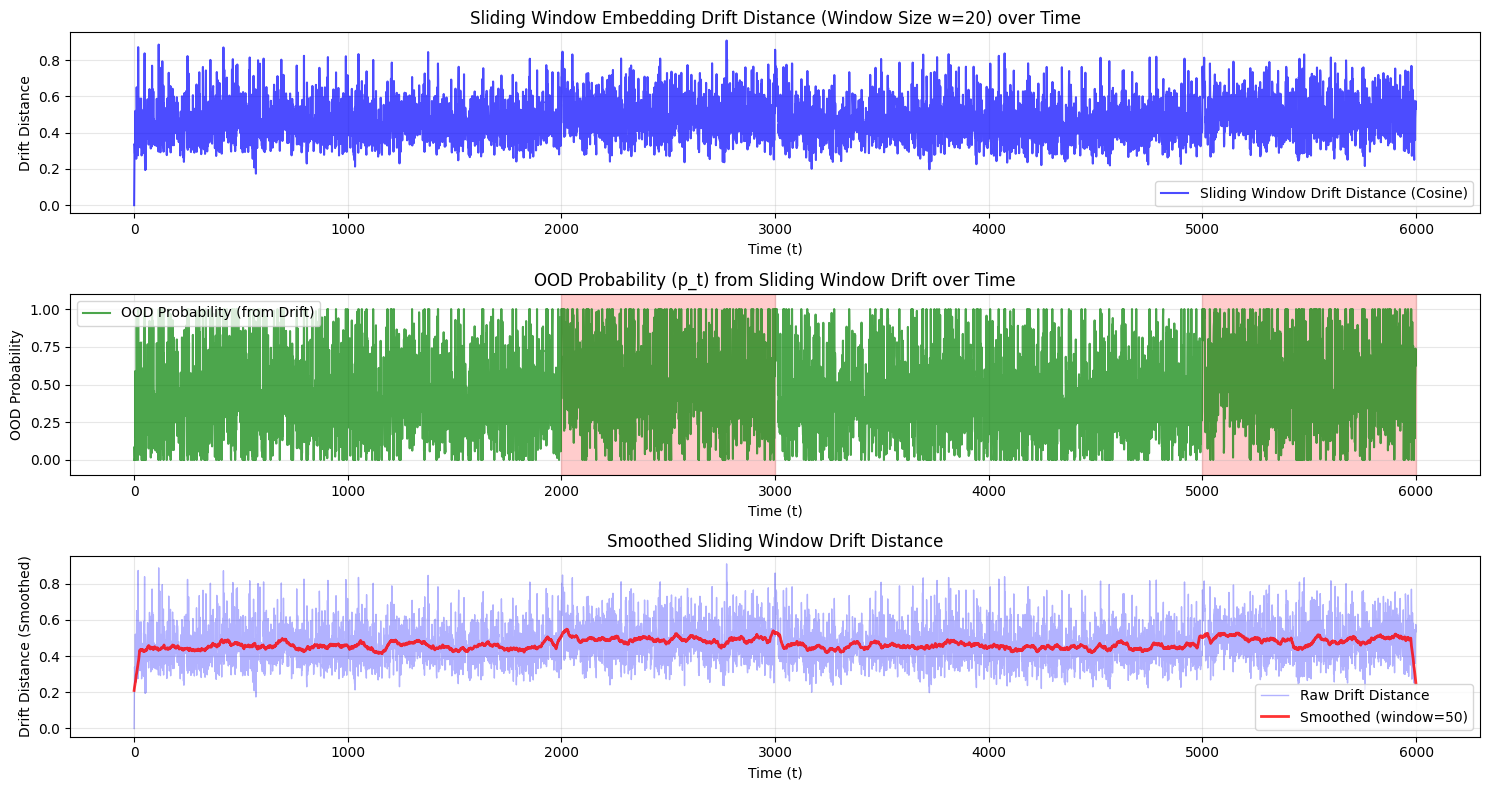

In [6]:
# -----------------------------------------------------------------
# Section 4: 计算滑动窗口嵌入漂移（Sliding Window Embedding Drift）用于控制 gamma
# -----------------------------------------------------------------
# 方案 A：基于滑动窗口的局部漂移检测
# 不比较 x_t 和 D_train (Calibration)，而是比较 x_t 和 D_recent (最近的 w 个样本)
# 逻辑：
#   - ID阶段：z_t 与 μ_window 相似 → 距离小 → γ 小
#   - Jump瞬间：z_t (新主题) 与 μ_window (旧主题) 差异巨大 → 距离激增 → γ 变大（快速适应）
#   - OOD稳定阶段：窗口内充满新主题样本，μ_window 更新为新主题均值 → 距离回落 → γ 变小（恢复稳定）

# === 预生成整条真实轨迹的 Embedding 向量 ===
# 1) 收集每个时间步的 embedding 向量
Z_full = []  # 存储每个时间步的 embedding 向量

for t in range(T):
    current_question_id = test_stream_df.loc[t, 'question_id']
    # 从 test_stream_df 中获取该问题的 embedding
    embedding = test_stream_df.loc[t, 'embedding']
    # 确保 embedding 是 numpy 数组
    if isinstance(embedding, list):
        embedding = np.array(embedding)
    Z_full.append(embedding)

Z_full = np.array(Z_full)  # Shape: (T, embedding_dim)
print(f"成功预生成 {len(Z_full)} 个时间步的 Embedding 向量。")
print(f"Embedding 维度: {Z_full.shape[1]}")
print(f"Embedding 统计: mean={Z_full.mean():.4f}, std={Z_full.std():.4f}")

# === 计算滑动窗口漂移距离 ===
# 对于每个时间步 t，计算 z_t 与最近 w 个样本均值 μ_window 的距离
w = SLIDING_WINDOW_SIZE
drift_distances = np.zeros(T)  # 存储每个时间步的漂移距离
window_means = []  # 存储每个时间步的窗口均值（用于可视化）

print(f"\n计算滑动窗口漂移距离 (窗口大小 w={w})...")

for t in range(T):
    z_t = Z_full[t]  # 当前时间步的 embedding 向量
    
    if t < w:
        # 如果窗口还没填满，使用已有的样本
        window_embeddings = Z_full[:t+1]  # 从开始到当前的所有样本
    else:
        # 窗口已填满，使用最近的 w 个样本
        window_embeddings = Z_full[t-w+1:t+1]  # 最近 w 个样本（包括当前）
    
    # 计算窗口内样本的均值
    mu_window = np.mean(window_embeddings, axis=0)  # Shape: (embedding_dim,)
    window_means.append(mu_window)
    
    # 计算当前样本与窗口均值的距离
    # 使用余弦距离（更稳定）或欧氏距离
    # 这里使用欧氏距离的平方（L2距离的平方）
    diff = z_t - mu_window
    euclidean_dist_sq = np.sum(diff ** 2)
    
    # 也可以使用余弦距离（归一化后更稳定）
    # 归一化向量
    z_t_norm = z_t / (np.linalg.norm(z_t) + 1e-8)
    mu_window_norm = mu_window / (np.linalg.norm(mu_window) + 1e-8)
    cosine_dist = 1.0 - np.dot(z_t_norm, mu_window_norm)  # 余弦距离 = 1 - 余弦相似度
    
    # 使用余弦距离作为漂移度量（更稳定，范围在[0, 2]）
    drift_distances[t] = cosine_dist

window_means = np.array(window_means)  # Shape: (T, embedding_dim)

print(f"\n滑动窗口漂移距离统计:")
print(f"  mean={drift_distances.mean():.4f}, std={drift_distances.std():.4f}")
print(f"  min={drift_distances.min():.4f}, max={drift_distances.max():.4f}")

# === 将漂移距离映射到 [0, 1] 得到 OOD 概率 p_t ===
# 使用分位数进行归一化，避免极端值
low = np.percentile(drift_distances, 5)
high = np.percentile(drift_distances, 95)
drift_clipped = np.clip(drift_distances, low, high)
ood_prob = (drift_clipped - low) / (high - low + 1e-8)

print(f"\nood_prob (from sliding window drift) range: {ood_prob.min():.4f}, {ood_prob.max():.4f}")

# === 可视化滑动窗口漂移距离和 ood_prob ===
plt.figure(figsize=(15, 8))
plt.subplot(3, 1, 1)
plt.plot(drift_distances, label='Sliding Window Drift Distance (Cosine)', color='blue', alpha=0.7, linewidth=1.5)
plt.title(f'Sliding Window Embedding Drift Distance (Window Size w={w}) over Time')
plt.xlabel('Time (t)')
plt.ylabel('Drift Distance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(ood_prob, label='OOD Probability (from Drift)', color='green', alpha=0.7, linewidth=1.5)
plt.title('OOD Probability (p_t) from Sliding Window Drift over Time')
plt.xlabel('Time (t)')
plt.ylabel('OOD Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)

# 添加时间段标记（如果有的话）
if 'time_segment_info' in globals():
    for start, end, seg_type, subject in time_segment_info:
        if seg_type == "OOD (jump)":
            plt.axvspan(start, end, alpha=0.2, color='red', label='OOD Jump' if start == time_segment_info[0][0] or start == time_segment_info[1][0] else '')

plt.subplot(3, 1, 3)
# 绘制漂移距离的移动平均（平滑）
smooth_window = 50
drift_smooth = np.convolve(drift_distances, np.ones(smooth_window)/smooth_window, mode='same')
plt.plot(drift_distances, label='Raw Drift Distance', color='blue', alpha=0.3, linewidth=1)
plt.plot(drift_smooth, label=f'Smoothed (window={smooth_window})', color='red', alpha=0.8, linewidth=2)
plt.title('Smoothed Sliding Window Drift Distance')
plt.xlabel('Time (t)')
plt.ylabel('Drift Distance (Smoothed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# --- 初始化算法状态 ---
# 1. Baseline (不学习)
alpha_baseline = np.full(T, TARGET_ALPHA)
err_baseline = []

# 2. ACI (固定 γ)
alpha_aci_fixed = np.zeros(T)
alpha_aci_fixed[0] = TARGET_ALPHA
err_aci_fixed = []

# 3. ACI-CF (我们的动态 γ_t, 使用滑动窗口漂移检测)
alpha_aci_ours = np.zeros(T)
alpha_aci_ours[0] = TARGET_ALPHA
err_aci_ours = []
gamma_t_history = []
p_t_history = []
p_gap_history = []
p_drift_history = []

# 初始化 p_drift (用于 EMA)
p_drift = ood_prob[0]  # 初始化为第一个值

# 按 question_id 分组，以便快速查询
test_stream_grouped = test_stream_full_df.groupby('question_id')

print("开始运行 MMLU 模拟...")
# --- 模拟 T 步 ---
for t in tqdm(range(T)):
    
    # 1. 获取当前 "世界" 状态（当前问题）
    current_question_id = test_stream_df.loc[t, 'question_id']
    current_ground_truth_label = test_stream_df.loc[t, 'ground_truth_label']
    
    # 2. 获取该问题的所有 4 个选项的数据
    question_choices_df = test_stream_grouped.get_group(current_question_id)

    # --- 算法 1: Baseline ---
    q_baseline = hat_Q(1.0 - alpha_baseline[t])
    set_baseline = question_choices_df[question_choices_df['aps_score'] <= q_baseline]['choice_index'].values
    is_error_baseline = 1.0 if current_ground_truth_label not in set_baseline else 0.0
    err_baseline.append(is_error_baseline)
    
    # --- 算法 2: ACI (固定 γ) ---
    alpha_aci_fixed[t] = np.clip(alpha_aci_fixed[t], 0.0, 1.0)
    q_aci_fixed = hat_Q(1.0 - alpha_aci_fixed[t])
    set_aci_fixed = question_choices_df[question_choices_df['aps_score'] <= q_aci_fixed]['choice_index'].values
    is_error_aci_fixed = 1.0 if current_ground_truth_label not in set_aci_fixed else 0.0
    err_aci_fixed.append(is_error_aci_fixed)
    
    if t < T-1:
        alpha_aci_fixed[t+1] = alpha_aci_fixed[t] + GAMMA_FIXED * (TARGET_ALPHA - is_error_aci_fixed)
        alpha_aci_fixed[t+1] = np.clip(alpha_aci_fixed[t+1], 0.0, 1.0)
        
    # --- 算法 3: ACI-CF (我们的动态 γ_t, 使用 RMD) ---
    alpha_aci_ours[t] = np.clip(alpha_aci_ours[t], 0.0, 1.0)
    q_aci_ours = hat_Q(1.0 - alpha_aci_ours[t])
    set_aci_ours = question_choices_df[question_choices_df['aps_score'] <= q_aci_ours]['choice_index'].values
    is_error_aci_ours = 1.0 if current_ground_truth_label not in set_aci_ours else 0.0
    err_aci_ours.append(is_error_aci_ours)
    
    # -----------------------------------------------------------------
    # *** 使用滑动窗口漂移检测控制 gamma ***
    # -----------------------------------------------------------------
    
    # 1) 使用预计算的 ood_prob[t]（基于滑动窗口漂移距离）
    #    这个值在 Cell 5 中已经计算好了，使用了全局归一化，更稳定
    # 2) Drift EMA (指数移动平均) - 平滑处理，避免噪声
    p_drift = 0.9 * p_drift + 0.1 * ood_prob[t]
    
    # （可选）叠加一个基于 error gap 的信号：
    if t < WINDOW_SIZE:
        avg_err = TARGET_ALPHA
    else:
        avg_err = np.mean(err_aci_ours[t-WINDOW_SIZE+1 : t+1])
    gap_t = abs(avg_err - TARGET_ALPHA)
    GAP_SCALE = 0.1
    p_gap = min(1.0, gap_t / GAP_SCALE)
    
    # 组合 p_t（这里我们主要使用 p_drift，也可以组合 p_gap）
    # p_t = max(p_drift, p_gap)
    # p_t = (p_drift + p_gap)/2
    p_t = p_drift  # 主要使用滑动窗口漂移检测

    # 5) 极简 γ_t：γ_t = γ_min + (γ_max - γ_min) * p_t
    gamma_t = GAMMA_MIN + (GAMMA_MAX - GAMMA_MIN) * p_t
    gamma_t_history.append(gamma_t)
    
    # 记录 p_t, p_gap, p_drift 的值
    p_t_history.append(p_t)
    p_gap_history.append(p_gap)
    p_drift_history.append(p_drift)
    
    # 更新 (下一轮使用)
    if t < T-1:
        alpha_aci_ours[t+1] = alpha_aci_ours[t] + gamma_t * (TARGET_ALPHA - is_error_aci_ours)
        alpha_aci_ours[t+1] = np.clip(alpha_aci_ours[t+1], 0.0, 1.0)

print("MMLU 模拟完成。")


开始运行 MMLU 模拟...


  0%|          | 0/6000 [00:00<?, ?it/s]

MMLU 模拟完成。


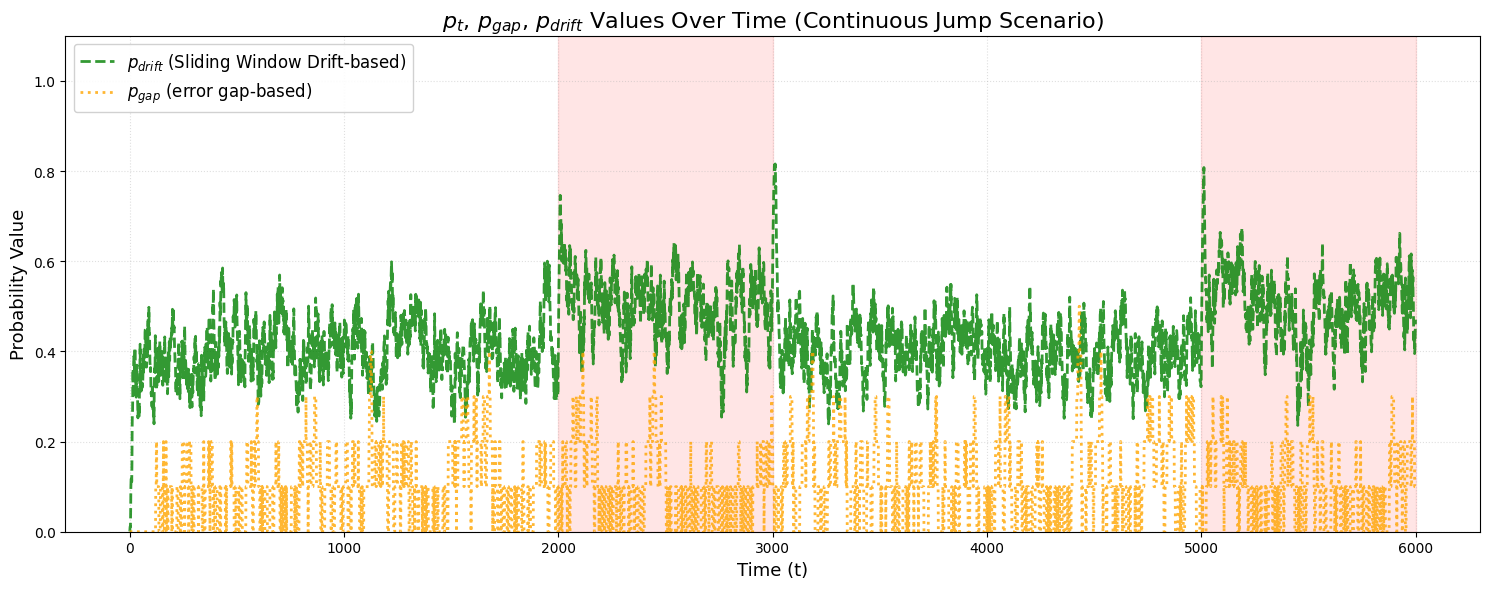

In [8]:
# --- 绘制 p_t, p_gap, p_drift 的变化图 ---
plt.figure(figsize=(15, 6))
plt.plot(p_drift_history, label='$p_{drift}$ (Sliding Window Drift-based)', color='green', linewidth=2, alpha=0.8, linestyle='--')
plt.plot(p_gap_history, label='$p_{gap}$ (error gap-based)', color='orange', linewidth=2, alpha=0.8, linestyle=':')

# 添加时间段标记（如果有的话）
if 'time_segment_info' in globals():
    for start, end, seg_type, subject in time_segment_info:
        if seg_type == "OOD (jump)":
            plt.axvspan(start, end, alpha=0.1, color='red')

plt.title("$p_t$, $p_{gap}$, $p_{drift}$ Values Over Time (Continuous Jump Scenario)", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Probability Value", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


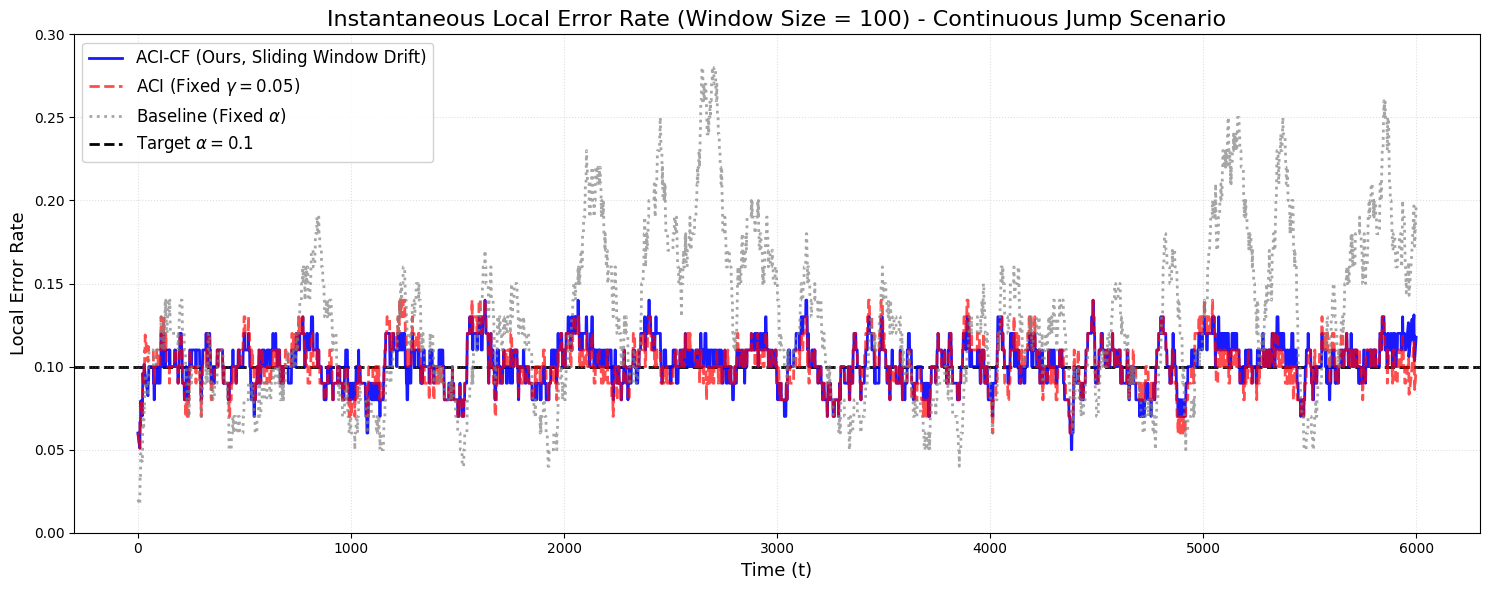

In [14]:
# --- "Instantaneous Local Error Rate Plot" ---
# 计算瞬时局部错误率（使用滑动窗口）

LOCAL_WINDOW_SIZE = 100  # 用于计算局部错误率的窗口大小

err_baseline_arr = np.array(err_baseline)
err_aci_fixed_arr = np.array(err_aci_fixed)
err_aci_ours_arr = np.array(err_aci_ours)

def compute_local_error_rate(err_array, window_size):
    """计算瞬时局部错误率"""
    local_error_rate = np.zeros(len(err_array))
    for t in range(len(err_array)):
        start_idx = max(0, t - window_size//2)
        local_error_rate[t] = np.mean(err_array[start_idx:t+window_size//2])
    return local_error_rate

local_err_baseline = compute_local_error_rate(err_baseline_arr, LOCAL_WINDOW_SIZE)
local_err_aci_fixed = compute_local_error_rate(err_aci_fixed_arr, LOCAL_WINDOW_SIZE)
local_err_aci_ours = compute_local_error_rate(err_aci_ours_arr, LOCAL_WINDOW_SIZE)

# 绘图
plt.figure(figsize=(15, 6))
plt.plot(local_err_aci_ours, label="ACI-CF (Ours, Sliding Window Drift)", color='blue', linewidth=2, alpha=0.9)
plt.plot(local_err_aci_fixed, label=f"ACI (Fixed $\\gamma={GAMMA_FIXED}$)", color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.plot(local_err_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linewidth=2, alpha=0.7, linestyle=':')
plt.axhline(TARGET_ALPHA, color='black', linestyle='--', linewidth=2, label=f'Target $\\alpha={TARGET_ALPHA}$', zorder=0)

plt.title(f"Instantaneous Local Error Rate (Window Size = {LOCAL_WINDOW_SIZE}) - Continuous Jump Scenario", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Local Error Rate", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(0, max(0.3, TARGET_ALPHA * 3))
plt.tight_layout()
plt.show()


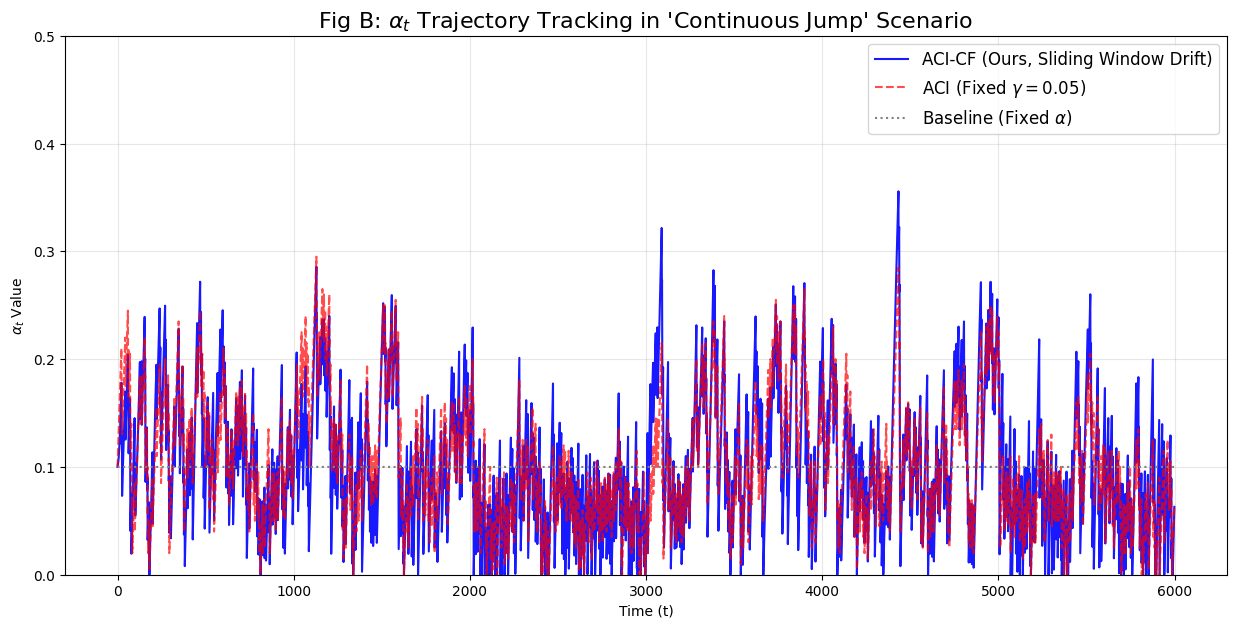

In [15]:
# --- "Money Plot": 追踪 α_t ---
plt.figure(figsize=(15, 7))
plt.plot(alpha_aci_ours, label="ACI-CF (Ours, Sliding Window Drift)", color='blue', alpha=0.9)
plt.plot(alpha_aci_fixed, label=f"ACI (Fixed $\\gamma={GAMMA_FIXED}$)", color='red', alpha=0.7, linestyle='--')
plt.plot(alpha_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linestyle=':')
plt.title("Fig B: $\\alpha_t$ Trajectory Tracking in 'Continuous Jump' Scenario", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("$\\alpha_t$ Value")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.5)
plt.show()


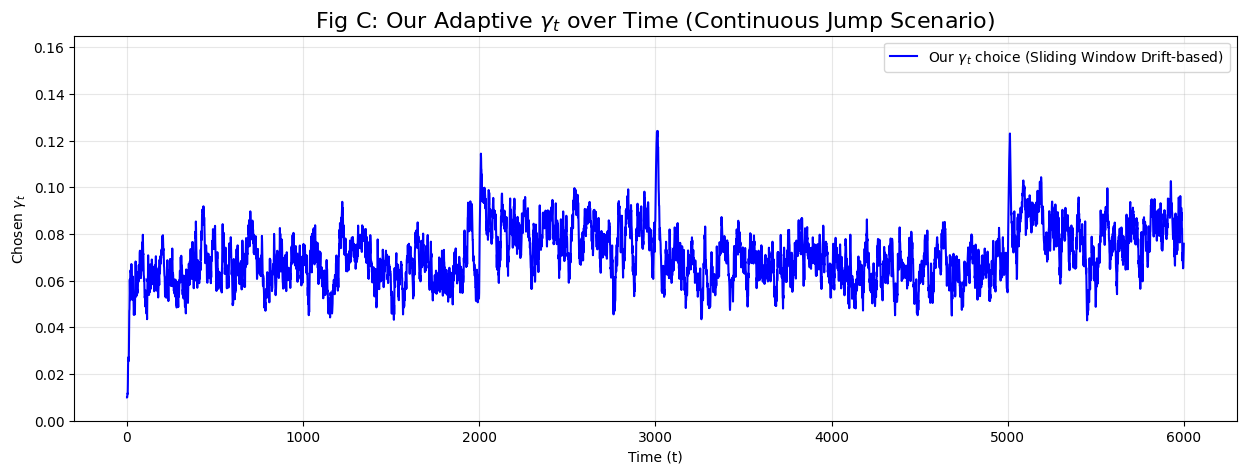

In [16]:
# --- "Why Plot": 我们选择的 γ_t ---
plt.figure(figsize=(15, 5))
plt.plot(gamma_t_history, label="Our $\\gamma_t$ choice (Sliding Window Drift-based)", color='blue')
plt.title("Fig C: Our Adaptive $\\gamma_t$ over Time (Continuous Jump Scenario)", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("Chosen $\\gamma_t$")
plt.ylim(0, GAMMA_MAX * 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


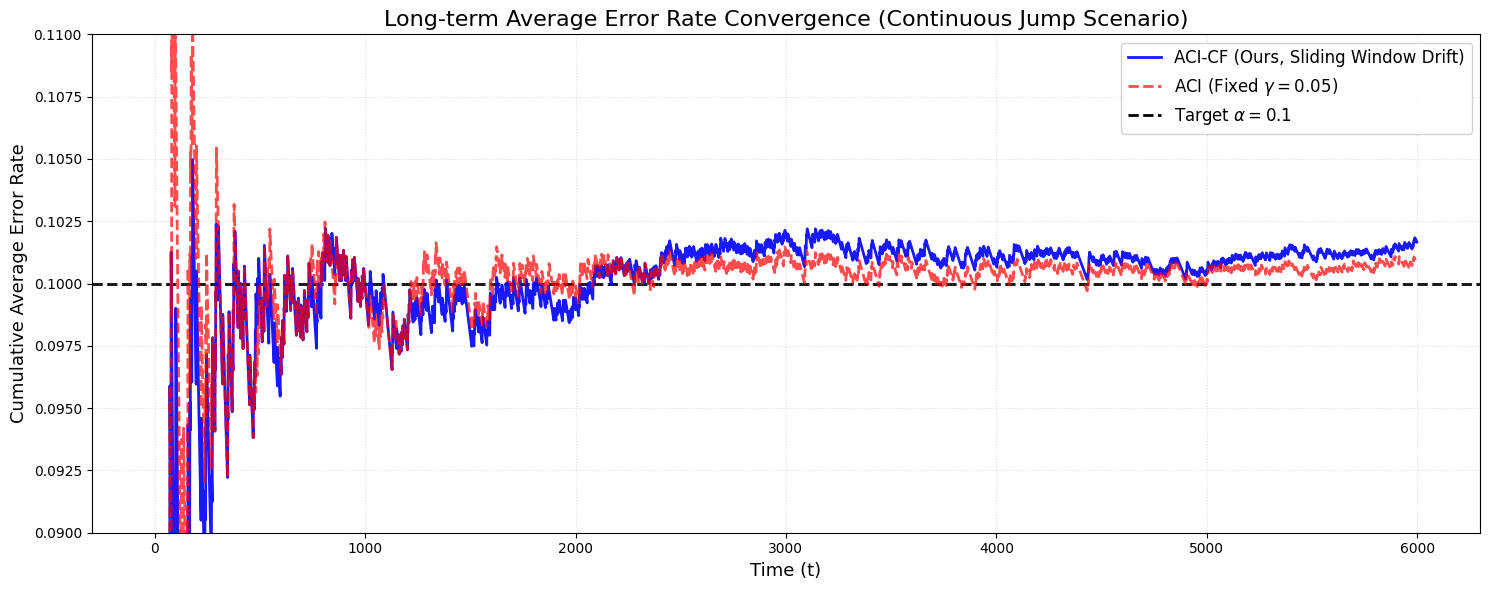

In [17]:
# --- "Long-term Average Error Rate Convergence" ---
err_baseline_arr = np.array(err_baseline)
err_aci_fixed_arr = np.array(err_aci_fixed)
err_aci_ours_arr = np.array(err_aci_ours)

def compute_cumulative_avg_error(err_array):
    """计算累积平均错误率"""
    cumulative_avg = np.zeros(len(err_array))
    for t in range(len(err_array)):
        cumulative_avg[t] = np.mean(err_array[0:t+1])
    return cumulative_avg

cumulative_avg_baseline = compute_cumulative_avg_error(err_baseline_arr)
cumulative_avg_aci_fixed = compute_cumulative_avg_error(err_aci_fixed_arr)
cumulative_avg_aci_ours = compute_cumulative_avg_error(err_aci_ours_arr)

# 绘图
plt.figure(figsize=(15, 6))
plt.plot(cumulative_avg_aci_ours, label="ACI-CF (Ours, Sliding Window Drift)", color='blue', linewidth=2, alpha=0.9)
plt.plot(cumulative_avg_aci_fixed, label=f"ACI (Fixed $\\gamma={GAMMA_FIXED}$)", color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.axhline(TARGET_ALPHA, color='black', linestyle='--', linewidth=2, label=f'Target $\\alpha={TARGET_ALPHA}$', zorder=0)

plt.title("Long-term Average Error Rate Convergence (Continuous Jump Scenario)", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Cumulative Average Error Rate", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(TARGET_ALPHA * 0.9, TARGET_ALPHA * 1.1)
plt.tight_layout()
plt.show()


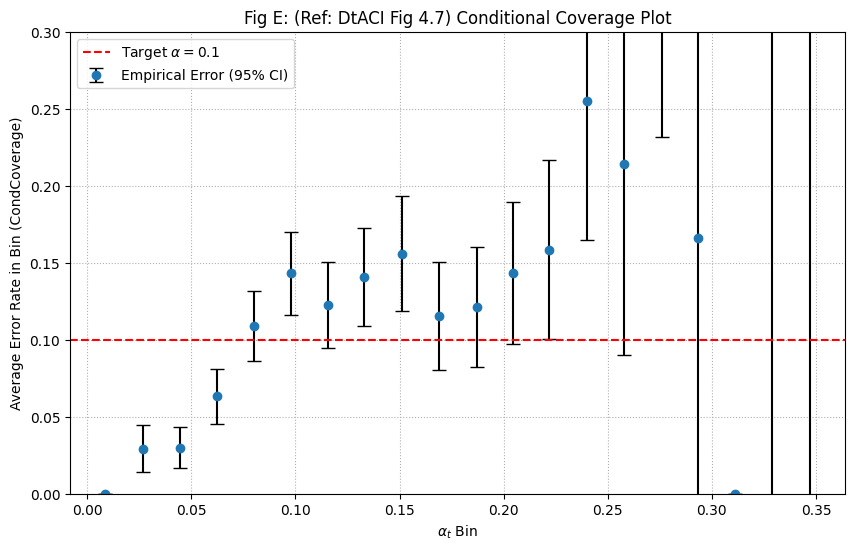

In [18]:
# --- "Stability Plot": 条件覆盖率 (Ref: Fig 4.7)  ---
df = pd.DataFrame({
    'alpha_t': alpha_aci_ours,
    'error': err_aci_ours
})

# 1. 将 α_t 分箱 (binning)
num_bins = 20
df['alpha_bin'] = pd.cut(df['alpha_t'], bins=num_bins)

# 2. 计算每个 bin 的统计数据（均值和样本数）
grouped = df.groupby('alpha_bin', observed=True)['error']
stats = grouped.agg(['mean', 'count'])

# 3. 计算 95% 置信区间 (95% CI)
p = stats['mean']
n = stats['count']
sem = np.sqrt(p * (1 - p) / n)
z_score = st.norm.ppf(0.975)  # 约等于 1.96
y_err = z_score * sem

# 准备绘图
bin_centers = [b.mid for b in stats.index]

# 4. 绘图 (使用 plt.errorbar)
plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, stats['mean'], yerr=y_err, fmt='o', color='C0',
             ecolor='black', capsize=5, label='Empirical Error (95% CI)')

plt.axhline(TARGET_ALPHA, color='red', linestyle='--', label=f'Target $\\alpha = {TARGET_ALPHA}$')

plt.xlabel("$\\alpha_t$ Bin")
plt.ylabel("Average Error Rate in Bin (CondCoverage)")
plt.title("Fig E: (Ref: DtACI Fig 4.7) Conditional Coverage Plot")
plt.legend()
plt.ylim(TARGET_ALPHA - 0.1, TARGET_ALPHA + 0.2)
plt.grid(True, linestyle=':')
plt.show()
